In [7]:
# Resource: https://www.kaggle.com/code/daggerx/modnet/notebook

In [1]:
# import gdown
import os
import torch
import shutil
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
from scipy.ndimage.morphology import grey_dilation, grey_erosion
import torch.nn.functional as F
import torchvision.transforms as transforms
from scipy.ndimage import morphology
import cv2
from torch.utils.data import DataLoader
from src.models.modnet import MODNet
from src.trainer import supervised_training_iter
from tqdm import tqdm

In [2]:
os.chdir("../..")
print(os.getcwd())
# dataset_path = "/datasets/matting_human_half"
ckpt_path = "pretrained/modnet_photographic_portrait_matting.ckpt"

E:\data\workspace\python\wanxiang-ai\MODNet


In [3]:
def cv2_imshow(image):

    # image = cv2.resize(image, (720, 480))

    cv2.imshow("img", image)
    #  add below code
    cv2.waitKey(0)
    cv2.destroyAllWindows()

import matplotlib
import matplotlib.pyplot as plt
def cv2plt(img):
    plt.figure(figsize=(7,7))        # To change the size of figure
    plt.axis('off')
    if np.size(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img,cmap='gray',vmin=0,vmax=255)
    plt.show()

print(cv2plt)

<function cv2plt at 0x0000016DFB5E6BF8>


In [4]:
# 大数据集
dataset_path = "../datasets/mini_matting_human_half"
data_csv = pd.DataFrame(columns=["images", "matte"])
image_dir = os.path.abspath(dataset_path)
image_list = list()
for folder in os.listdir(image_dir):
#     if folder==".DS_Store":
#     continue
    for batch in os.listdir(os.path.join(image_dir, folder)):
        for clip in os.listdir(os.path.join(image_dir, folder, batch)):
            if clip=="._matting_00000000":
                continue
            for img in os.listdir(os.path.join(image_dir, folder, batch, clip)):
                # print(img)
                image = os.path.join(image_dir, folder, batch, clip, img)
                image_list.append(image)

data_csv["images"]=image_list
data_csv["matte"] = data_csv["images"]
data_csv["matte"] = data_csv["matte"].str.replace("jpg", "png").str.replace("clip_img", "matting").str.replace("clip_", "matting_")
data_csv

,images,matte
0,E:\data\workspace\python\wanxiang-ai\datasets\...,E:\data\workspace\python\wanxiang-ai\datasets\...
1,E:\data\workspace\python\wanxiang-ai\datasets\...,E:\data\workspace\python\wanxiang-ai\datasets\...
2,E:\data\workspace\python\wanxiang-ai\datasets\...,E:\data\workspace\python\wanxiang-ai\datasets\...
3,E:\data\workspace\python\wanxiang-ai\datasets\...,E:\data\workspace\python\wanxiang-ai\datasets\...
4,E:\data\workspace\python\wanxiang-ai\datasets\...,E:\data\workspace\python\wanxiang-ai\datasets\...
...,...,...
921,E:\data\workspace\python\wanxiang-ai\datasets\...,E:\data\workspace\python\wanxiang-ai\datasets\...
922,E:\data\workspace\python\wanxiang-ai\datasets\...,E:\data\workspace\python\wanxiang-ai\datasets\...
923,E:\data\workspace\python\wanxiang-ai\datasets\...,E:\data\workspace\python\wanxiang-ai\datasets\...
924,E:\data\workspace\python\wanxiang-ai\datasets\...,E:\data\workspace\python\wanxiang-ai\datasets\...


# 读取小数据集图片
dataset_path = "../datasets/PPM-100"
data_csv = pd.DataFrame(columns=["images", "matte"])
image_dir = os.path.abspath(dataset_path)
print(image_dir)
image_list = list()
for folder in os.listdir(image_dir):
#     if folder==".DS_Store":
#     continue
    for img in os.listdir(os.path.join(image_dir, folder)):
#             print(img)
        image = os.path.join(image_dir, folder, img)
        image_list.append(image)

data_csv["images"]=image_list
data_csv["matte"] = data_csv["images"]
data_csv["matte"] = data_csv["matte"].str.replace("jpg", "png").str.replace("image", "matte")

In [5]:
#drop the corrupted entry from the data frame
# data_csv.drop(22428, 0, inplace=True)

In [6]:
class ModNetDataLoader(Dataset):
    def __init__(self, annotations_file, resize_dim, transform=None):
        self.img_labels =annotations_file
        self.transform=transform
        self.resize_dim=resize_dim

    def __len__(self):
        #return the total number of images
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx,0]
        mask_path = self.img_labels.iloc[idx,1]
        print(img_path)
        print(mask_path)

        img = np.asarray(Image.open(img_path))

        in_image = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        # cv2_imshow(in_image)

        # 本数据集只有3个通道
        mask = in_image[:,:,3]
        # mask = in_image[:,:,3]
        # 检查图像通道数
        # if in_image.shape[2] == 4:
        #     # 如果有4个通道，那么提取Alpha通道
        #     mask = in_image[:, :, 3]
        # elif in_image.shape[2] == 3:
        #     # 如果只有3个通道，可以选择创建一个全白（或全黑）的Alpha通道
        #     mask = np.ones_like(in_image[:, :, 0]) * 255
        # else:
        #     print("Unexpected number of channels in the image.")

        if len(img.shape)==2:
            img = img[:,:,None]
        if img.shape[2]==1:
            img = np.repeat(img, 3, axis=2)
        elif img.shape[2]==4:
            img = img[:,:,0:3]

        if len(mask.shape)==3:
            mask = mask[:,:, 0]

        #convert Image to pytorch tensor
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)
        if self.transform:
            img = self.transform(img)
            trimap = self.get_trimap(mask)
            mask = self.transform(mask)

        img = self._resize(img)
        mask = self._resize(mask)
        trimap = self._resize(trimap, trimap=True)

        img = torch.squeeze(img, 0)
        mask = torch.squeeze(mask, 0)
        trimap = torch.squeeze(trimap, 1)

        return img, trimap, mask

    def get_trimap(self, alpha):
        # alpha \in [0, 1] should be taken into account
        # be careful when dealing with regions of alpha=0 and alpha=1
        fg = np.array(np.equal(alpha, 255).astype(np.float32))
        unknown = np.array(np.not_equal(alpha, 0).astype(np.float32)) # unknown = alpha > 0
        unknown = unknown - fg
        # image dilation implemented by Euclidean distance transform
        unknown = morphology.distance_transform_edt(unknown==0) <= np.random.randint(1, 20)
        trimap = fg
        trimap[unknown] = 0.5
        return torch.unsqueeze(torch.from_numpy(trimap), dim=0)#.astype(np.uint8)

    def _resize(self, img, trimap=False):
        im = img[None, :, :, :]
        ref_size = self.resize_dim

        # resize image for input
        im_b, im_c, im_h, im_w = im.shape
        if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
            if im_w >= im_h:
                im_rh = ref_size
                im_rw = int(im_w / im_h * ref_size)
            elif im_w < im_h:
                im_rw = ref_size
                im_rh = int(im_h / im_w * ref_size)
        else:
            im_rh = im_h
            im_rw = im_w

        im_rw = im_rw - im_rw % 32
        im_rh = im_rh - im_rh % 32
        if trimap == True:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='nearest')
        else:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='area')
        return im

In [7]:
transformer = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)
            )
        ]
    )
data = ModNetDataLoader(data_csv, 512, transform=transformer)

In [14]:
img, trimap, mask = data[2]
# 打印图像、matte 和 trimap 的形状
print("Image shape:", img.shape)
print("Trimap shape:", trimap.shape)
print("Matte shape:", mask.shape)

E:\data\workspace\python\wanxiang-ai\datasets\mini_matting_human_half\clip_img\1803151818\clip_00000000\1803151818-00000008.jpg
E:\data\workspace\python\wanxiang-ai\datasets\mini_matting_human_half\matting\1803151818\matting_00000000\1803151818-00000008.png
Image shape: torch.Size([3, 672, 512])
Trimap shape: torch.Size([1, 672, 512])
Matte shape: torch.Size([1, 672, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


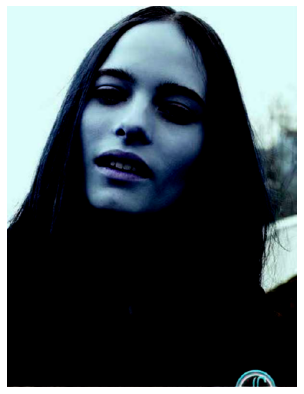

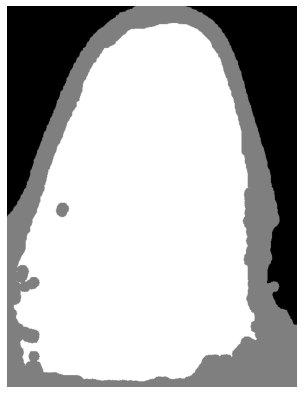

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


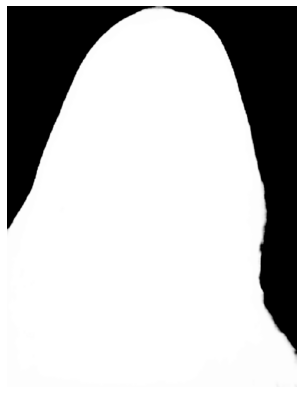

In [15]:
def img_transpose(img):
    return img.numpy().transpose(2,1,0).transpose(1,0,2)

img_t = img_transpose(img)
trimap_t = img_transpose(trimap)
mask_t = img_transpose(mask)

cv2plt(img_t)
cv2plt(trimap_t)
cv2plt(mask_t)

In [46]:
# ckpt_path = "pretrained/mobilenetv2_human_seg.ckpt"
train_dataloader = DataLoader(data, batch_size=8, shuffle=True)
# state_dict = torch.load(ckpt_path)
# state_dict["epoch"]

In [47]:
import torch
from src.models.modnet import MODNet
from src.trainer import supervised_training_iter
bs = 16         # batch size
lr = 0.01       # learn rate
epochs = 40     # total epochs

# modnet = torch.nn.DataParallel(MODNet()).cuda()
modnet = torch.nn.DataParallel(MODNet(backbone_pretrained=True)).cuda()
optimizer = torch.optim.SGD(modnet.parameters(), lr=lr, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(0.25 * epochs), gamma=0.1)

for epoch in range(0, epochs):
    for idx, (image, trimap, gt_matte) in enumerate(train_dataloader):
        semantic_loss, detail_loss, matte_loss = \
            supervised_training_iter(modnet, optimizer, image.cuda(), trimap.cuda(), gt_matte.cuda())
    lr_scheduler.step()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 7.25 GiB already allocated; 0 bytes free; 7.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
in_image = cv2.imread("1.png", cv2.IMREAD_UNCHANGED)

# 检查图像通道数
in_image.shape

(366, 400)